In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import xgboost
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

In [2]:
GENERAL_PATH = '../data/interim/'
drough_features = pd.read_csv(f'{GENERAL_PATH}drought_data_features.csv', index_col=0)
meteorological_features = pd.read_csv(f'{GENERAL_PATH}meteorological_data_features.csv', index_col=0)
neighbour_features = pd.read_csv(f'{GENERAL_PATH}drought_data_neighbour_features.csv', index_col=0)
targets = pd.read_csv(f'{GENERAL_PATH}drought_data_targets.csv', index_col=0)
additional_data = pd.read_csv(f'{GENERAL_PATH}drought_data.csv', index_col=0)

In [6]:
all_features = pd.concat([drough_features, meteorological_features, neighbour_features,], axis=1)

In [11]:
target = 'DROUGHT_INDEX__NEXT_MONTHS6'

In [8]:
additional_data.DATE = pd.to_datetime(additional_data.DATE)
additional_data.NEW_DATE = pd.to_datetime(additional_data.NEW_DATE)

In [9]:
available_features = all_features[all_features.isna().sum()[all_features.isna().sum()<300000].index]
available_features = available_features[available_features.isna().sum(axis=1) < 88]

In [12]:
available_targets = targets[targets[target].notna()]

In [13]:
available_info = pd.Index(set(available_targets.index).intersection(set(available_features.index)))

In [14]:
X = all_features.loc[available_info][available_features.columns]
y =(available_targets.loc[available_info][target] > 0).astype(int)

available_data = additional_data.loc[available_info]
MIN_DATE_INFO = available_data.DATE.min()
MAX_DATE_INFO = available_data.DATE.max()

PROPOSED_DATE = pd.to_datetime('2020-01-01')

In [17]:
train_window = available_data[
    available_data.DATE.between(MIN_DATE_INFO, PROPOSED_DATE)
].index

oot_window = available_data[
    available_data.DATE.between(PROPOSED_DATE, MAX_DATE_INFO)
].index

In [18]:
x_train, x_test, y_train, y_test = train_test_split(
    X.loc[train_window], 
    y.loc[train_window], 
    train_size=0.9)

x_oot, y_oot = X.loc[oot_window], y.loc[oot_window]


x_oot, x_dev, y_oot, y_dev = train_test_split(
    x_oot, 
    y_oot, 
    train_size=0.5)

In [19]:
del X
del y

In [20]:
params = {
    'n_estimators':50,
    'max_depth':4,
    'learning_rate': 0.01,
    'subsample':0.8,
    'colsample_bytree': 0.8,
    'random_state': 42
}

In [21]:
model = xgboost.XGBClassifier(**params)
model.fit(
    x_train, 
    y_train, 
    eval_set=[(x_train, y_train), (x_dev, y_dev)], 
    early_stopping_rounds=3,
    eval_metric=['aucpr', 'auc', 'logloss']
)

/mnt/c/Users/dhdzm/Documents/projects/seguia/venv/lib/python3.8/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/mnt/c/Users/dhdzm/Documents/projects/seguia/venv/lib/python3.8/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-aucpr:0.31841	validation_0-auc:0.69515	validation_0-logloss:0.68810	validation_1-aucpr:0.38301	validation_1-auc:0.64498	validation_1-logloss:0.68992
[1]	validation_0-aucpr:0.33381	validation_0-auc:0.70856	validation_0-logloss:0.68316	validation_1-aucpr:0.39885	validation_1-auc:0.66759	validation_1-logloss:0.68680
[2]	validation_0-aucpr:0.33906	validation_0-auc:0.71266	validation_0-logloss:0.67831	validation_1-aucpr:0.39440	validation_1-auc:0.66646	validation_1-logloss:0.68368
[3]	validation_0-aucpr:0.34241	validation_0-auc:0.71395	validation_0-logloss:0.67354	validation_1-aucpr:0.39783	validation_1-auc:0.67062	validation_1-logloss:0.68066
[4]	validation_0-aucpr:0.34629	validation_0-auc:0.71429	validation_0-logloss:0.66888	validation_1-aucpr:0.39964	validation_1-auc:0.67105	validation_1-logloss:0.67771
[5]	validation_0-aucpr:0.34692	validation_0-auc:0.71312	validation_0-logloss:0.66431	validation_1-aucpr:0.39891	validation_1-auc:0.67072	validation_1-logloss:0.67483
[6]	

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=50, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=42, ...)

In [22]:
pred_oot = model.predict_proba(x_oot)[:, 1]
pred_test = model.predict_proba(x_test)[:, 1]

<Axes: ylabel='Percent'>

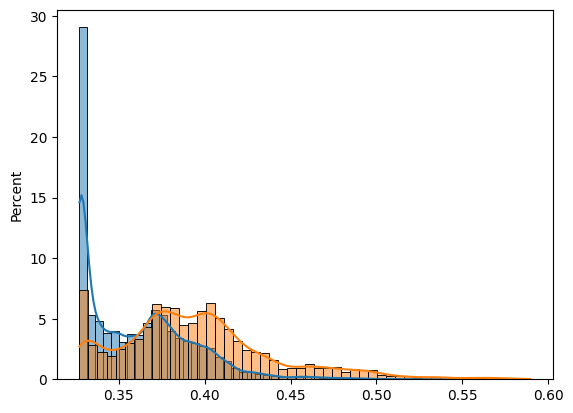

In [23]:
sns.histplot(pred_test[y_test==0], bins=50, stat='percent', kde=True)
sns.histplot(pred_test[y_test==1], bins=50, stat='percent', kde=True)

<Axes: ylabel='Count'>

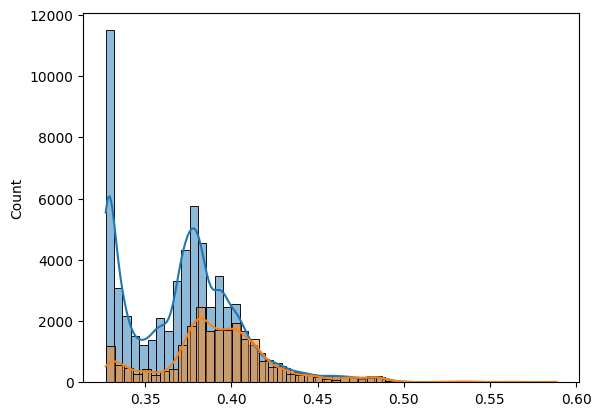

In [24]:
sns.histplot(pred_oot[y_oot==0], bins=50, kde=True)
sns.histplot(pred_oot[y_oot==1], bins=50, kde=True)

In [25]:
additional_data_with_pred_oot = additional_data.loc[x_oot.index].copy()
additional_data_with_pred_oot['pred'] = pred_oot
additional_data_with_pred_oot['y'] = y_oot

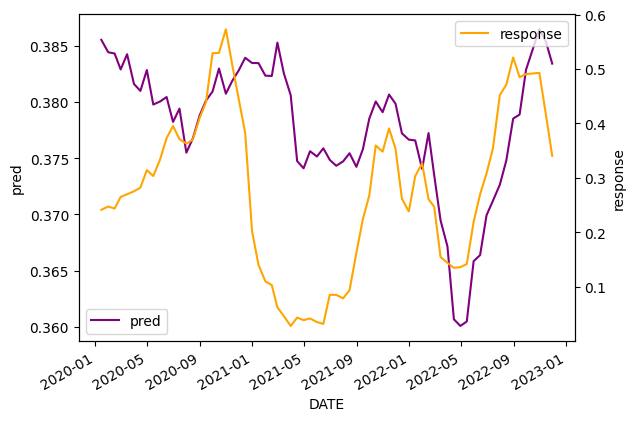

In [31]:
ax = additional_data_with_pred_oot.groupby('DATE').pred.mean().plot(label='pred', color='purple')
plt.legend()
plt.ylabel('pred')


ax3 = ax.twinx()

additional_data_with_pred_oot.groupby('DATE').y.mean().plot(ax=ax3, color='orange', label='response')
plt.ylabel('response')
plt.legend()
#additional_data_with_pred_oot.groupby('DATE').DROUGHT_INDEX.mean().plot(
#    ax=ax2, color='r', linestyle='--', label='actual drough_index'
#)

In [36]:
additional_data_with_pred_oot.groupby('DATE')[['pred', 'y', 'DROUGHT_INDEX']].mean().corr(method='spearman')

,pred,y,DROUGHT_INDEX
pred,1.000000,0.294848,-0.096200
y,0.294848,1.000000,-0.320607
DROUGHT_INDEX,-0.096200,-0.320607,1.000000


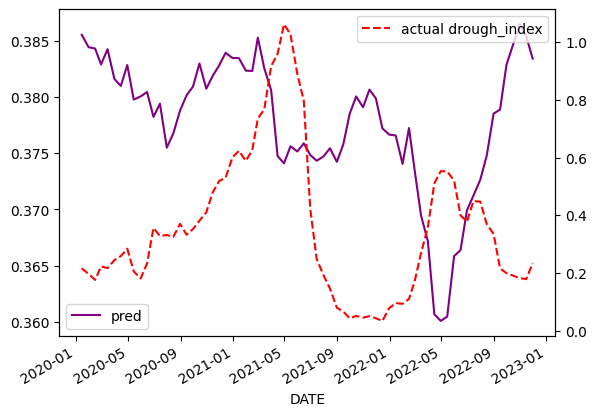

In [29]:
ax = additional_data_with_pred_oot.groupby('DATE').pred.mean().plot(label='pred', color='purple')
plt.legend()

ax3 = ax.twinx()

additional_data_with_pred_oot.groupby('DATE').DROUGHT_INDEX.mean().plot(
    ax=ax3, color='r', linestyle='--', label='actual drough_index'
)
plt.legend()


In [22]:
roc_auc_score(y_oot, pred_oot)

def get_auc(df):
    return roc_auc_score(df.y, df.pred)

<Axes: xlabel='DATE'>

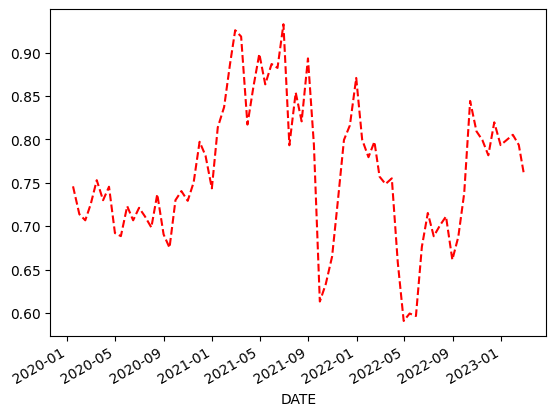

In [23]:
additional_data_with_pred_oot.groupby('DATE').apply(get_auc).plot(linestyle='--', color='r')

In [54]:
 #pip install shap